step 1: choosing a dataset - Life Expectancy (WHO)

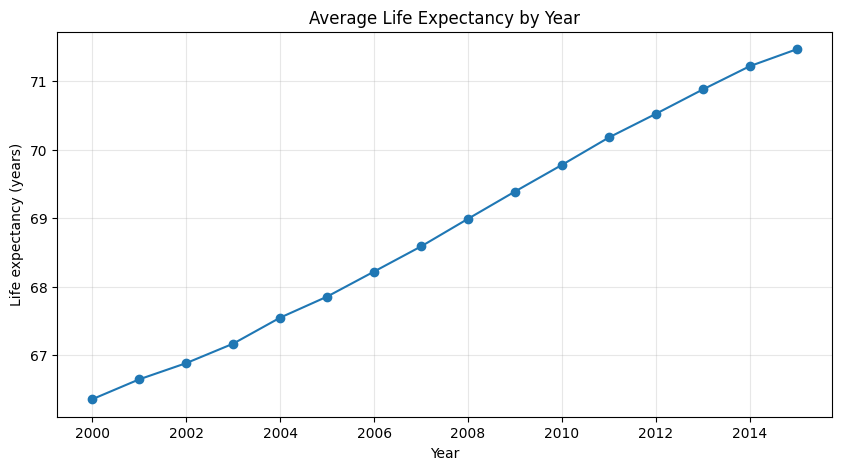

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv("Life-Expectancy-Data-Updated.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Make sure the key columns are numeric
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Life_expectancy"] = pd.to_numeric(df["Life_expectancy"], errors="coerce")

# Keep only rows where we can plot
df_plot = df.dropna(subset=["Year", "Life_expectancy"]).copy()
df_plot["Year"] = df_plot["Year"].astype(int)

df_plot[["Year", "Life_expectancy"]].describe()

yearly = (
    df_plot.groupby("Year", as_index=False)["Life_expectancy"]
    .mean()
    .sort_values("Year")
)

plt.figure(figsize=(10, 5))
plt.plot(yearly["Year"], yearly["Life_expectancy"], marker="o")
plt.title("Average Life Expectancy by Year")
plt.xlabel("Year")
plt.ylabel("Life expectancy (years)")
plt.grid(True, alpha=0.3)
plt.show()





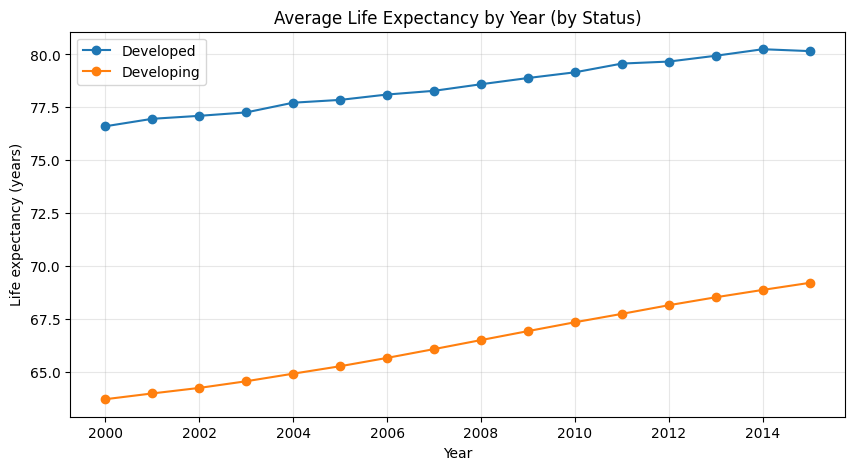

In [4]:

# 2. CREATE THE 'STATUS' COLUMN
# The new data has 1s and 0s. We map them back to "Developed" or "Developing"
# so your plotting logic has a label to use.
df['Status'] = df['Economy_status_Developed'].apply(lambda x: 'Developed' if x == 1 else 'Developing')

# 3. YOUR ORIGINAL LOGIC (Updated with correct column names)
# Note: The CSV uses "Life_expectancy" (with underscore), not "Life expectancy"
yearly_status = (
    df.groupby(["Year", "Status"])["Life_expectancy"]
    .mean()
    .reset_index()
    .sort_values("Year")
)

plt.figure(figsize=(10, 5))

# Loop through the groups to plot lines
for status, g in yearly_status.groupby("Status"):
    plt.plot(g["Year"], g["Life_expectancy"], marker="o", label=status)

plt.title("Average Life Expectancy by Year (by Status)")
plt.xlabel("Year")
plt.ylabel("Life expectancy (years)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

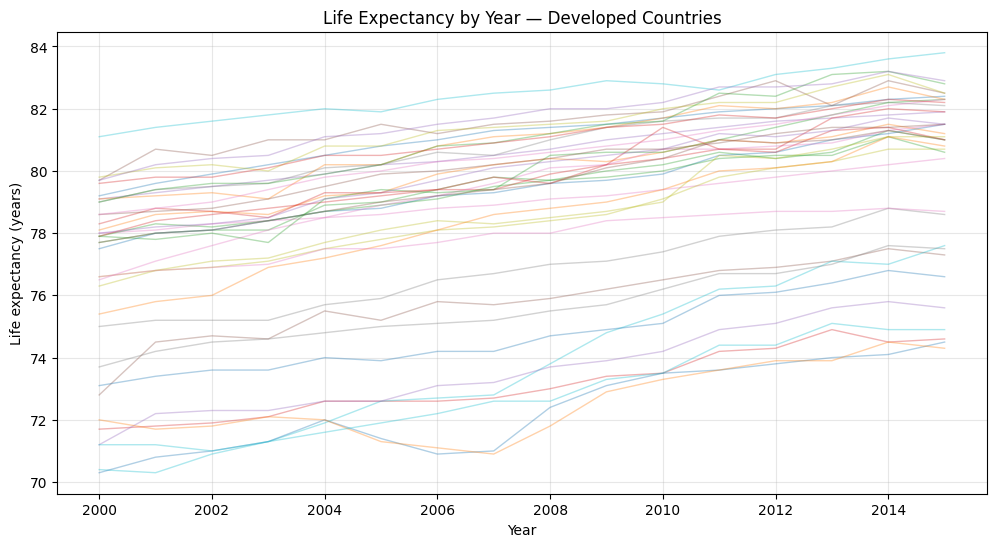

In [5]:
dev = df[df["Status"].str.strip().eq("Developed")].copy()

# Average within (Country, Year) in case duplicates exist
dev_yearly = (
    dev.groupby(["Country", "Year"], as_index=False)["Life_expectancy"]
    .mean()
    .sort_values(["Country", "Year"])
)

developed_countries = sorted(dev_yearly["Country"].unique())
len(developed_countries), developed_countries[:10]

plt.figure(figsize=(12, 6))

for country, g in dev_yearly.groupby("Country"):
    plt.plot(g["Year"], g["Life_expectancy"], alpha=0.35, linewidth=1)

plt.title("Life Expectancy by Year — Developed Countries")
plt.xlabel("Year")
plt.ylabel("Life expectancy (years)")
plt.grid(True, alpha=0.3)
plt.show()


###### vaccination and life span by year

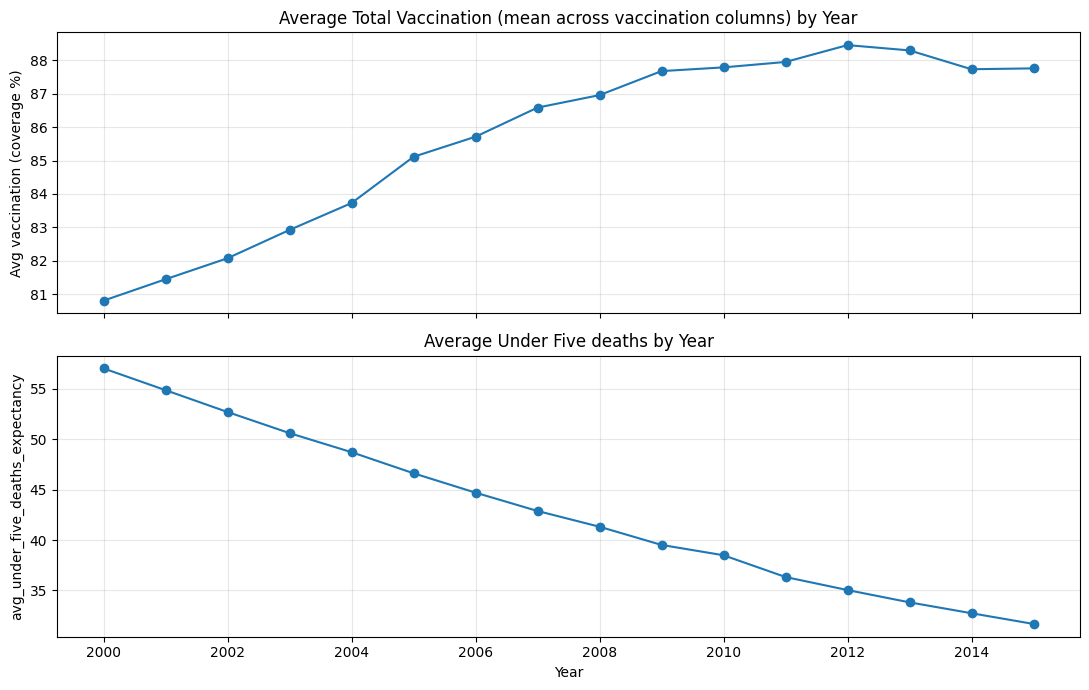

In [10]:
# Auto-detect vaccination columns (edit keywords if you want to include/exclude more)
vacc_keywords = ["hepatitis", "polio", "diphtheria", "immunization", "vacc"]

vacc_cols = [
    c for c in df.columns
    if any(k in c.lower() for k in vacc_keywords)
]

for c in vacc_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["avg_vaccination"] = df[vacc_cols].mean(axis=1, skipna=True)

yearly = (
    df.dropna(subset=["Year"])
      .groupby("Year", as_index=False)
      .agg(
          avg_under_five_deaths_expectancy=("Under_five_deaths", "mean"),
          avg_total_vaccination=("avg_vaccination", "mean"),
      )
      .sort_values("Year")
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 7), sharex=True)

# Plot 1: vaccination
axes[0].plot(yearly["Year"], yearly["avg_total_vaccination"], marker="o")
axes[0].set_title("Average Total Vaccination (mean across vaccination columns) by Year")
axes[0].set_ylabel("Avg vaccination (coverage %)")
axes[0].grid(True, alpha=0.3)

# Plot 2: life expectancy
axes[1].plot(yearly["Year"], yearly["avg_under_five_deaths_expectancy"], marker="o")
axes[1].set_title("Average Under Five deaths by Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("avg_under_five_deaths_expectancy")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



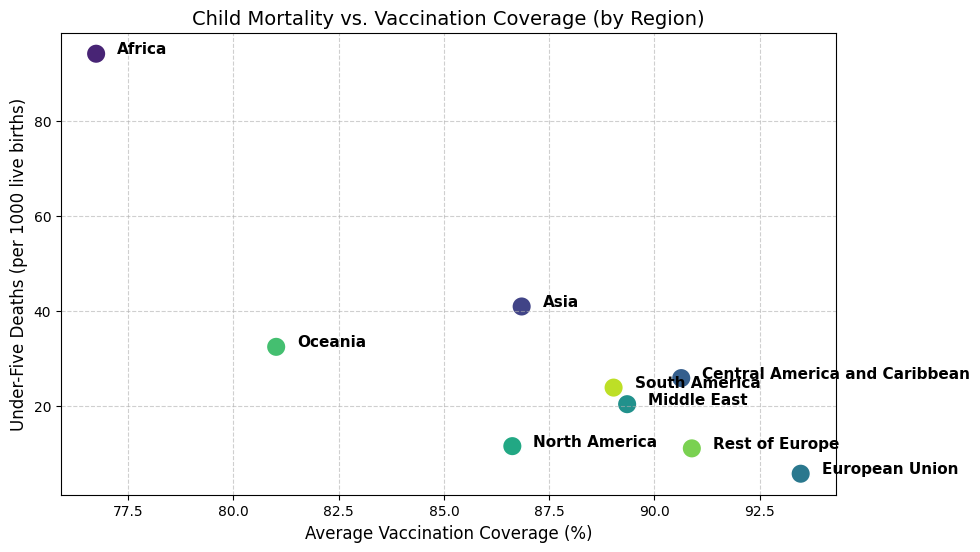

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Pre-process: Calculate Average Vaccination per Row
# Identify vaccination columns automatically
vacc_keywords = ["hepatitis", "polio", "diphtheria", "immunization", "vacc"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["avg_vaccination"] = df[vacc_cols].mean(axis=1, skipna=True)

# 3. Aggregate by Region
region_stats = (
    df.groupby("Region")
    .agg(
        avg_vaccination=("avg_vaccination", "mean"),
        avg_child_mortality=("Under_five_deaths", "mean")
    )
    .reset_index()
)

# 4. Plot: Vaccination vs Child Mortality
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=region_stats, 
    x="avg_vaccination", 
    y="avg_child_mortality", 
    s=200,                # Marker size
    hue="Region",         # Color by Region
    palette="viridis",
    legend=False          # Turn off legend if we label points directly
)

# 5. Add Labels to Points
for i in range(region_stats.shape[0]):
    plt.text(
        region_stats.avg_vaccination[i] + 0.5,  # Offset X slightly
        region_stats.avg_child_mortality[i],    # Y position
        region_stats.Region[i], 
        fontsize=11, 
        fontweight='bold'
    )

plt.title("Child Mortality vs. Vaccination Coverage (by Region)", fontsize=14)
plt.xlabel("Average Vaccination Coverage (%)", fontsize=12)
plt.ylabel("Under-Five Deaths (per 1000 live births)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [14]:
df.loc[df["Region"] == "Asia"]

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy,avg_vaccination
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4,63.666667
18,Japan,Asia,2005,2.8,3.7,68.7680,7.98,83,84,22.6,...,0.17,33099,127.77,1.7,1.5,11.2,1,0,81.9,92.000000
21,Philippines,Asia,2001,28.2,36.9,214.2685,4.53,45,19,22.3,...,0.01,1847,79.67,1.0,9.7,7.7,0,1,68.8,66.666667
26,Kazakhstan,Asia,2006,25.6,29.0,270.9885,6.76,99,99,25.8,...,0.08,7838,15.31,2.4,2.5,11.7,0,1,66.2,99.000000
30,Bhutan,Asia,2005,44.7,57.5,253.2655,0.73,95,76,22.8,...,0.19,1489,0.65,17.8,18.6,2.3,0,1,65.3,95.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,Brunei Darussalam,Asia,2009,7.8,9.6,91.9455,0.24,96,99,26.3,...,0.10,32992,0.38,6.0,5.5,8.7,0,1,74.6,98.000000
2853,Lao PDR,Asia,2000,76.5,107.2,274.4510,5.19,48,65,21.1,...,0.10,936,5.32,1.5,1.5,3.9,0,1,58.8,52.000000
2856,Japan,Asia,2014,2.1,2.8,55.5820,8.40,83,94,22.7,...,0.17,34387,127.28,2.0,1.7,12.5,1,0,83.6,92.666667
2860,Mongolia,Asia,2009,23.9,28.6,235.2330,6.56,97,97,25.3,...,0.02,2515,2.67,2.2,2.3,9.1,0,1,66.9,96.000000


C:\Users\Shir\AppData\Local\Temp\ipykernel_95832\2919103358.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Shir\AppData\Local\Temp\ipykernel_95832\2919103358.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


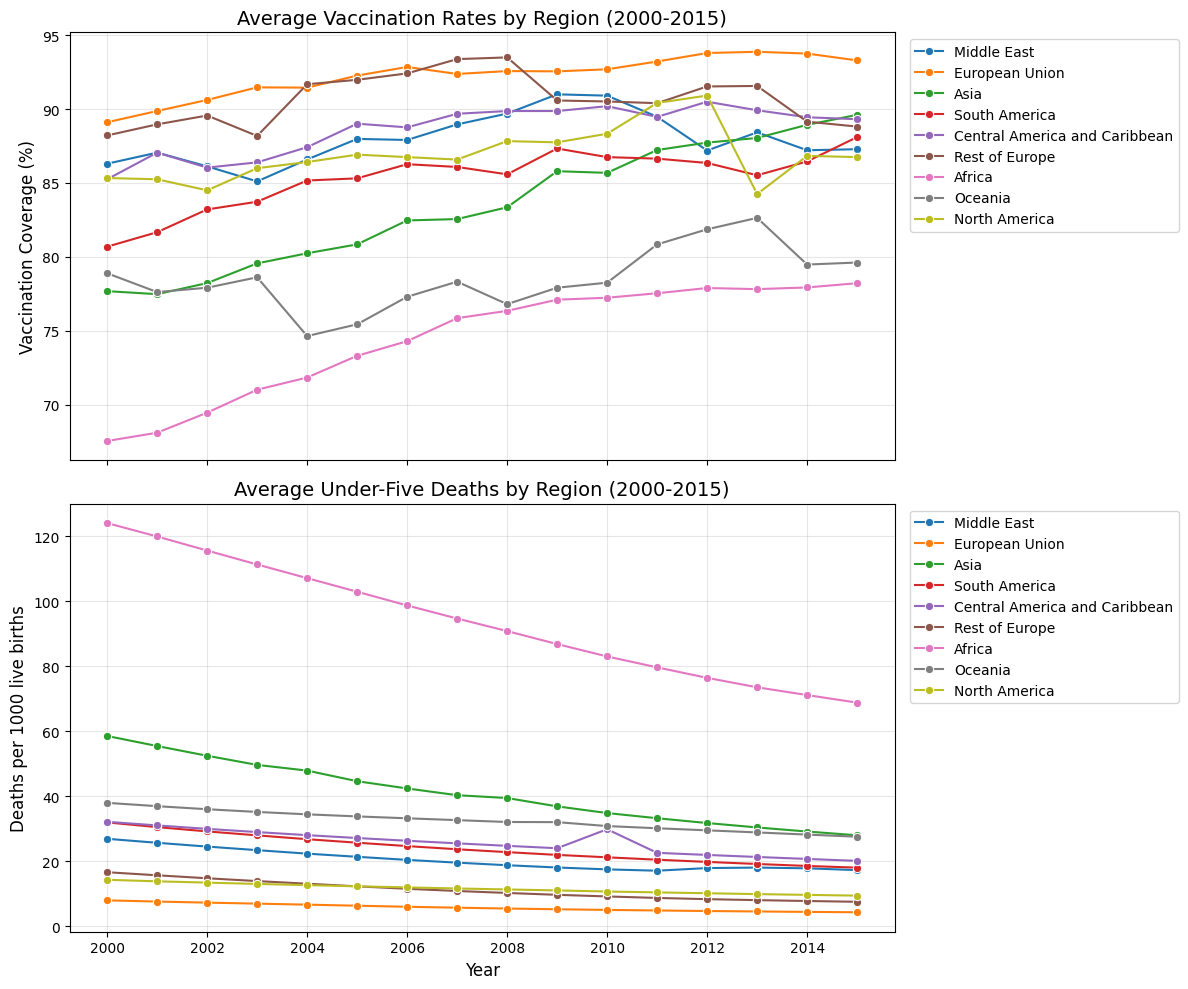

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Prepare Vaccination Data
# Identify vaccination columns (Polio, Hepatitis_B, Diphtheria)
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in ["polio", "hepatitis", "diphtheria", "measles"])]

# Calculate the average vaccination rate for each row (Country/Year)
df['avg_vaccination'] = df[vacc_cols].mean(axis=1)

# 3. Create Plots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Plot 1: Vaccination Rate per Region over Years ---
sns.lineplot(
    data=df, 
    x="Year", 
    y="avg_vaccination", 
    hue="Region", 
    ax=axes[0],
    marker="o",
    ci=None  # Remove confidence interval shading for cleaner lines
)
axes[0].set_title("Average Vaccination Rates by Region (2000-2015)", fontsize=14)
axes[0].set_ylabel("Vaccination Coverage (%)", fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# --- Plot 2: Child Mortality per Region over Years ---
sns.lineplot(
    data=df, 
    x="Year", 
    y="Under_five_deaths", 
    hue="Region", 
    ax=axes[1],
    marker="o",
    ci=None
)
axes[1].set_title("Average Under-Five Deaths by Region (2000-2015)", fontsize=14)
axes[1].set_ylabel("Deaths per 1000 live births", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

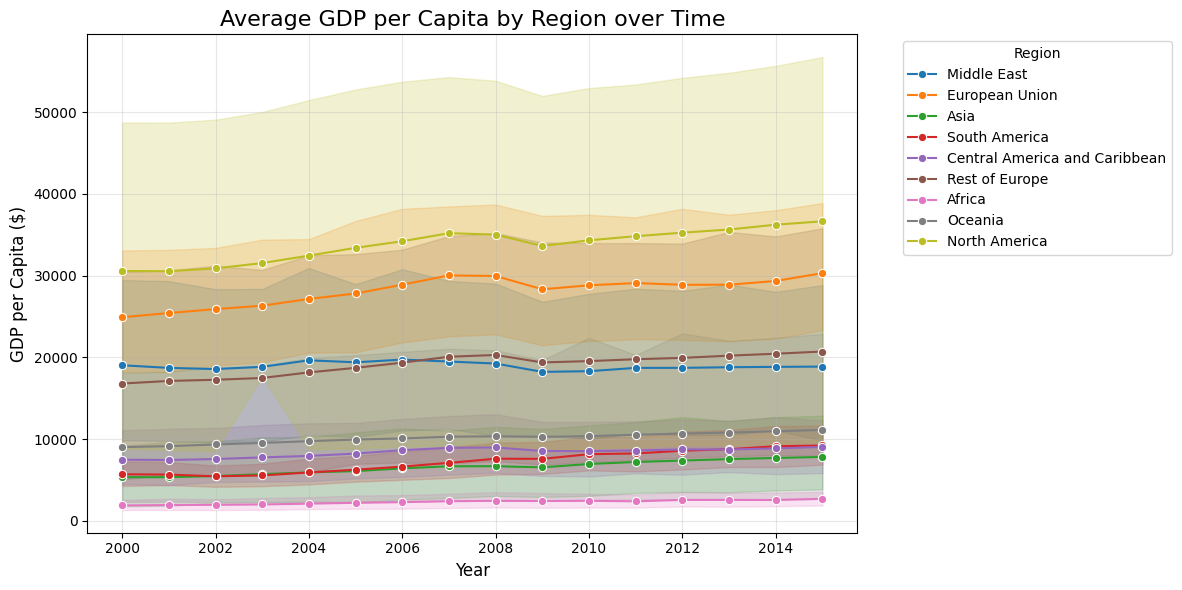

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Create the Plot
plt.figure(figsize=(12, 6))

# sns.lineplot automatically calculates the average GDP for all countries in a region for each year
sns.lineplot(
    data=df, 
    x='Year', 
    y='GDP_per_capita', 
    hue='Region', 
    marker='o'
)

# 3. Formatting
plt.title('Average GDP per Capita by Region over Time', fontsize=16)
plt.ylabel('GDP per Capita ($)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Correlation Coefficient: -0.4697


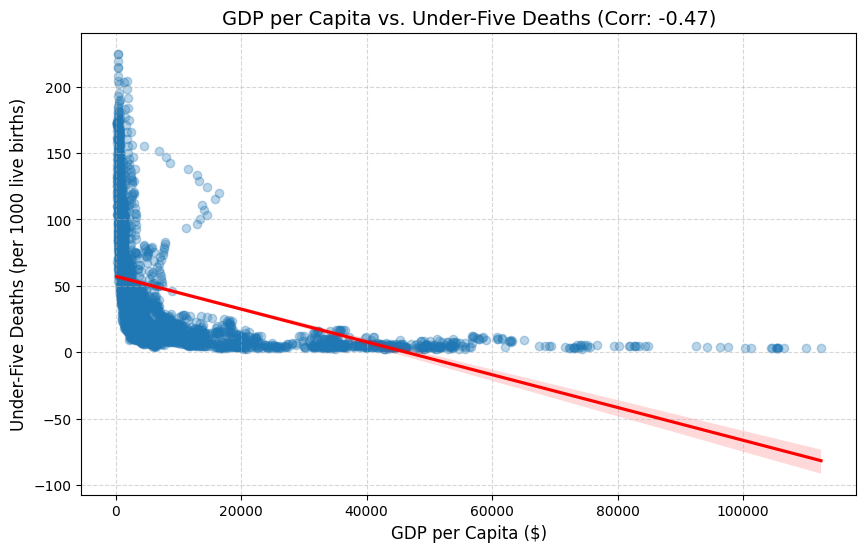

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Calculate the specific correlation number
# The result will be between -1 (perfect negative) and 1 (perfect positive)
correlation = df['Under_five_deaths'].corr(df['GDP_per_capita'])
print(f"Correlation Coefficient: {correlation:.4f}")

# 3. Visualizing the Correlation
plt.figure(figsize=(10, 6))

# regplot draws the scatter plot AND fits a linear regression line (red)
sns.regplot(
    data=df, 
    x='GDP_per_capita', 
    y='Under_five_deaths',
    scatter_kws={'alpha': 0.3}, # Makes points transparent to see density
    line_kws={'color': 'red'}   # The regression line color
)

plt.title(f'GDP per Capita vs. Under-Five Deaths (Corr: {correlation:.2f})', fontsize=14)
plt.xlabel('GDP per Capita ($)', fontsize=12)
plt.ylabel('Under-Five Deaths (per 1000 live births)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Log GDP vs Vaccination):
Status             
Developed   log_GDP   -0.332358
Developing  log_GDP    0.536635
Name: avg_vaccination, dtype: float64


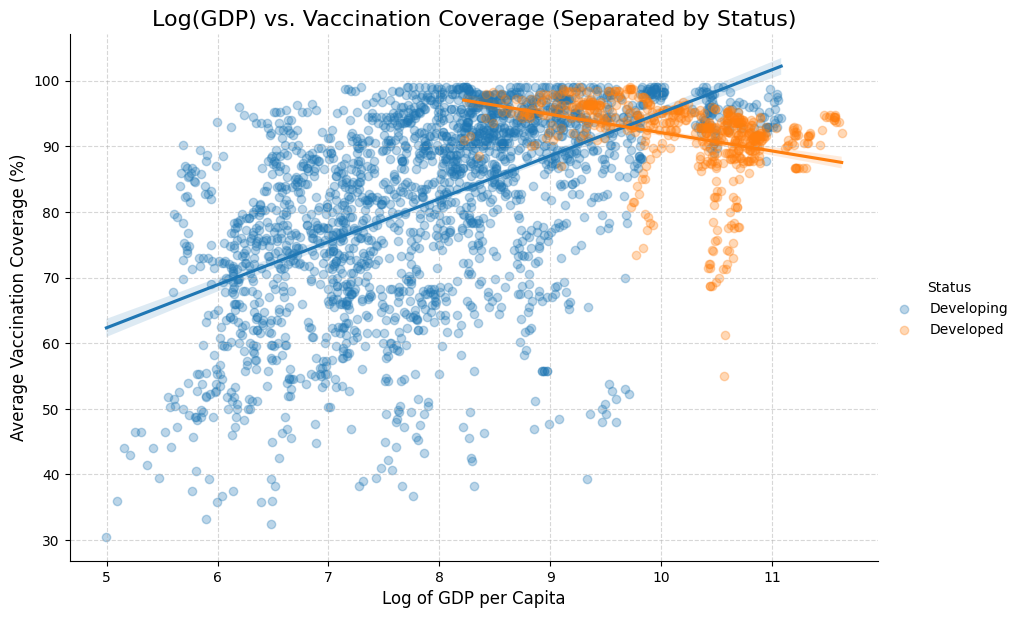

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Prepare Data
# Create 'Status' column (Developed/Developing)
df['Status'] = df['Economy_status_Developed'].apply(lambda x: 'Developed' if x == 1 else 'Developing')

# Calculate Average Vaccination
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in ["hepatitis", "polio", "diphtheria", "measles"])]
df['avg_vaccination'] = df[vacc_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)

# Calculate Log GDP (for better visualization)
df['log_GDP'] = np.log(df['GDP_per_capita'])

# 3. Calculate Correlations for each group
stats = df.groupby('Status')[['log_GDP', 'avg_vaccination']].corr().iloc[0::2, -1]
print("Correlation (Log GDP vs Vaccination):")
print(stats)

# 4. Plot
# lmplot draws scatter plots with regression lines for each 'hue' category
sns.lmplot(
    data=df, 
    x='log_GDP', 
    y='avg_vaccination', 
    hue='Status', 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3}
)

plt.title('Log(GDP) vs. Vaccination Coverage (Separated by Status)', fontsize=16)
plt.xlabel('Log of GDP per Capita', fontsize=12)
plt.ylabel('Average Vaccination Coverage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Developed Countries): 0.1011


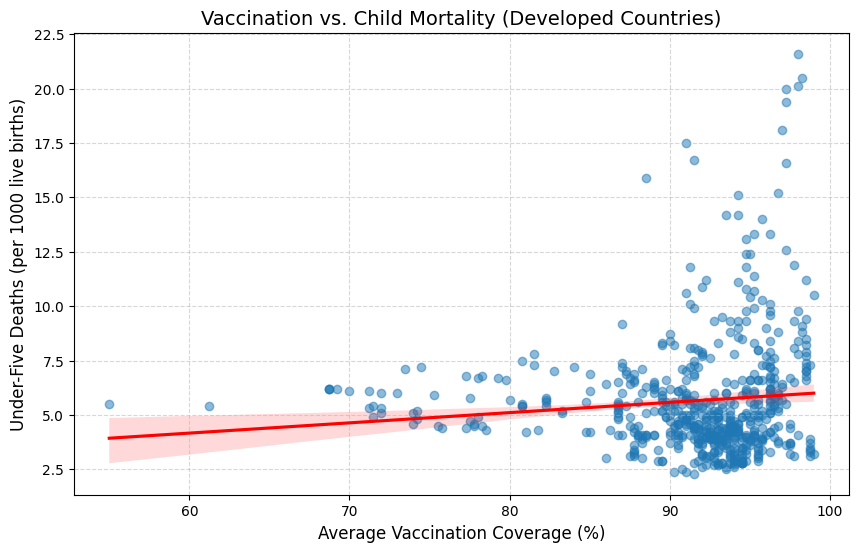

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Filter for Developed Countries
# The column 'Economy_status_Developed' uses 1 for Developed
developed_df = df[df['Economy_status_Developed'] == 1].copy()

# 3. Calculate Average Vaccination
vacc_keywords = ["hepatitis", "polio", "diphtheria", "measles"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    developed_df[c] = pd.to_numeric(developed_df[c], errors='coerce')

developed_df['avg_vaccination'] = developed_df[vacc_cols].mean(axis=1)

# 4. Calculate Correlation
correlation = developed_df['avg_vaccination'].corr(developed_df['Under_five_deaths'])
print(f"Correlation (Developed Countries): {correlation:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))

sns.regplot(
    data=developed_df,
    x='avg_vaccination',
    y='Under_five_deaths',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Child Mortality (Developed Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel('Under-Five Deaths (per 1000 live births)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Developing Countries): -0.7086


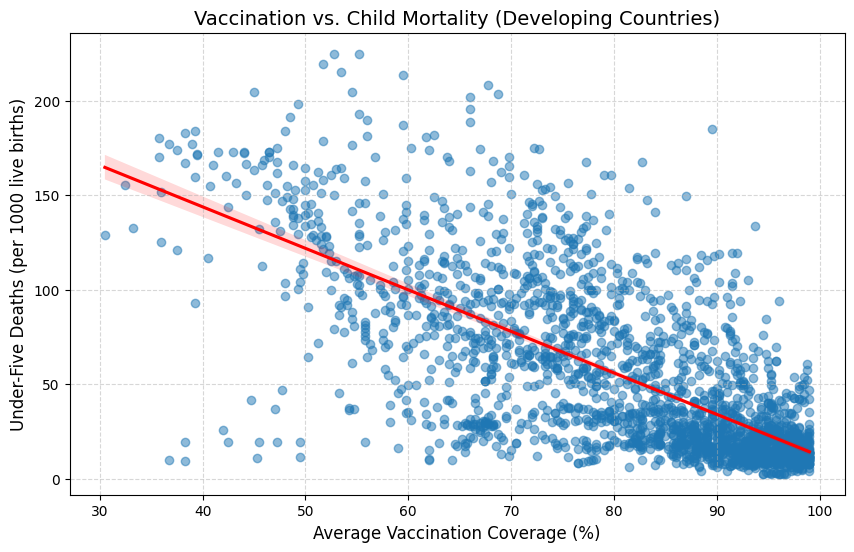

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Filter for Developed Countries
# The column 'Economy_status_Developed' uses 1 for Developed
developing_df = df[df['Economy_status_Developing'] == 1].copy()

# 3. Calculate Average Vaccination
vacc_keywords = ["hepatitis", "polio", "diphtheria", "measles"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    developing_df[c] = pd.to_numeric(developing_df[c], errors='coerce')

developing_df['avg_vaccination'] = developing_df[vacc_cols].mean(axis=1)

# 4. Calculate Correlation
correlation = developing_df['avg_vaccination'].corr(developing_df['Under_five_deaths'])
print(f"Correlation (Developing Countries): {correlation:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))

sns.regplot(
    data=developing_df,
    x='avg_vaccination',
    y='Under_five_deaths',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Child Mortality (Developing Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel('Under-Five Deaths (per 1000 live births)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Developed Countries): -0.2905


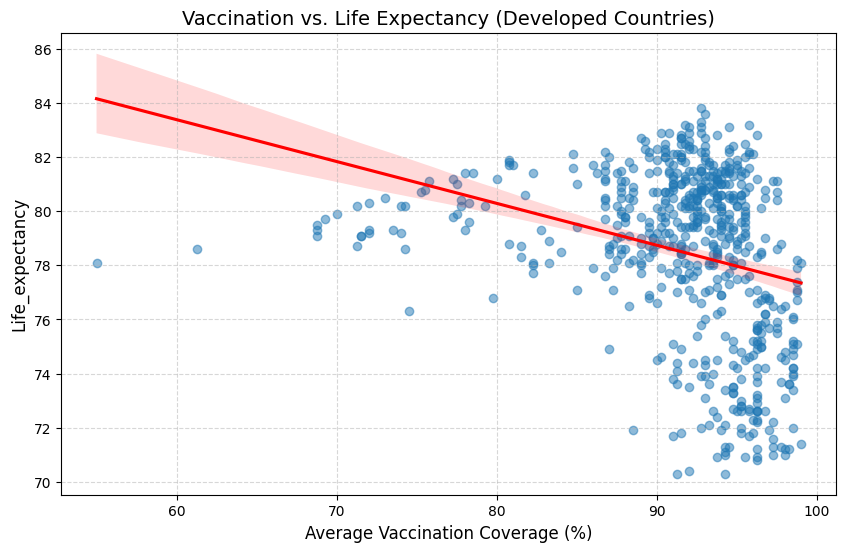

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Filter for Developed Countries
# The column 'Economy_status_Developed' uses 1 for Developed
developed_df = df[df['Economy_status_Developed'] == 1].copy()

# 3. Calculate Average Vaccination
vacc_keywords = ["hepatitis", "polio", "diphtheria", "measles"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    developed_df[c] = pd.to_numeric(developed_df[c], errors='coerce')

developed_df['avg_vaccination'] = developed_df[vacc_cols].mean(axis=1)

# 4. Calculate Correlation
correlation = developed_df['avg_vaccination'].corr(developed_df['Life_expectancy'])
print(f"Correlation (Developed Countries): {correlation:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))

sns.regplot(
    data=developed_df,
    x='avg_vaccination',
    y='Life_expectancy',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Life Expectancy (Developed Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel("Life_expectancy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Developing Countries): 0.6258


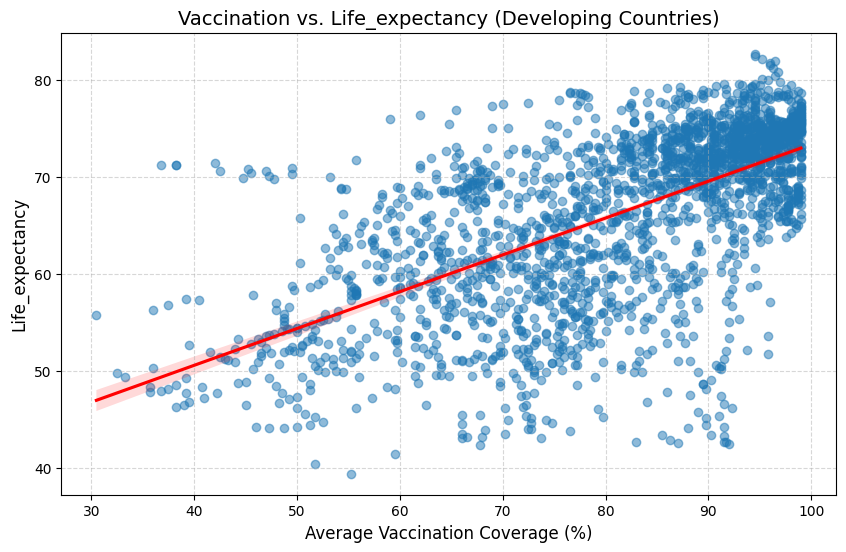

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Filter for Developed Countries
# The column 'Economy_status_Developed' uses 1 for Developed
developing_df = df[df['Economy_status_Developing'] == 1].copy()

# 3. Calculate Average Vaccination
vacc_keywords = ["hepatitis", "polio", "diphtheria", "measles"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    developing_df[c] = pd.to_numeric(developing_df[c], errors='coerce')

developing_df['avg_vaccination'] = developing_df[vacc_cols].mean(axis=1)

# 4. Calculate Correlation
correlation = developing_df['avg_vaccination'].corr(developing_df['Life_expectancy'])
print(f"Correlation (Developing Countries): {correlation:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))

sns.regplot(
    data=developing_df,
    x='avg_vaccination',
    y='Life_expectancy',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Life_expectancy (Developing Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel('Life_expectancy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()